### Part 1: Choose open-source LLM to generate embeddings
### Part 2: Download dataset “Netflix Reviews”

In [36]:
import pandas as pd
df = pd.read_csv("netflix_reviews.csv")
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,1bd2041f-0a90-4089-a9ac-8d3c593e65e6,Brand SA Chea,So great & reliable,5,0,NaN,2024-06-17 21:28:48,NaN
1,fff52ee7-b0f8-4a5b-a125-fd2c65a0b99d,tony lags,Netflix Jan 14 2015,5,0,8.118.1 build 10 50703,2024-06-17 21:25:58,8.118.1 build 10 50703
2,60e7140e-cec4-4c21-aeba-0e16c4e8879c,Otte “HiROMi” Hilmi,The subtitles ALWAYS didn't show up if I don't...,2,0,8.118.1 build 10 50703,2024-06-17 21:21:09,8.118.1 build 10 50703
3,d851f774-8a57-4eee-b26f-7432ab7e9cfd,Meg M,its netflix nothing rong with it,5,0,8.118.1 build 10 50703,2024-06-17 21:13:22,8.118.1 build 10 50703
4,4d8cdc86-7698-45df-95fb-4a5b21981c1d,a random guy,I love trattors,4,0,8.75.0 build 6 50446,2024-06-17 21:06:18,8.75.0 build 6 50446
...,...,...,...,...,...,...,...,...
113545,a760ead9-e7aa-4ed1-a651-5c37c3600dac,A Google user,i really like it! there are so many movies and...,5,0,NaN,2019-08-03 15:06:03,NaN
113546,4957f9e7-d7f4-4a52-9764-031cebcac83f,Captain Jeoy,I love Netflix. I always enjoy my time using it.,5,0,8.34.0 build 4 50250,2022-08-15 16:16:30,8.34.0 build 4 50250
113547,9acf7586-7abf-4b50-8c50-3ede3b2a42c4,Suryansh,Sound quality is very slow of movies,1,0,NaN,2020-08-17 07:26:58,NaN
113548,32870f7f-c461-4256-b602-75244ca60248,A Google user,Rate is very expensive.. bcos we see netflix s...,1,0,7.17.0 build 13 34346,2019-07-21 09:41:42,7.17.0 build 13 34346


In [37]:
new_df = df.groupby('score', group_keys=False).apply(lambda x: x.sample(n=400)).reset_index(drop = True)

/tmp/ipykernel_2994/2371705718.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_df = df.groupby('score', group_keys=False).apply(lambda x: x.sample(n=400)).reset_index(drop = True)


In [38]:
new_df = new_df[["content", "score"]].sample(frac=1).reset_index(drop=True)
new_df

,content,score
0,Well streaming crashes from time to time,3
1,Its really nice to see thousands of movies and...,5
2,I love netflix especialy for my child No ads E...,5
3,Honestly I've had Netflix for a long time and ...,3
4,I can't add anything to my list. When I touch ...,2
...,...,...
1995,Easy to watch my favorite shows. Check out new...,5
1996,"I love Netflix, always something new and excit...",5
1997,It's great but being a naruto fun I thought I ...,4
1998,"Netflix has most of every movie, I love it.",5


In [39]:
#!pip install -U sentence-transformers

In [40]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Part 3: Use LLM of your choice to create embeddings of your data. Put them on the table.
#### Sentence-transformers/paraphrase-MiniLM-L6-v2

This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2

In [41]:
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
sentences = new_df['content'].tolist()

model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

embeddings = []
for sentence in tqdm(sentences, desc="Encoding sentences"):
    embedding = model.encode(sentence)
    embeddings.append(embedding)

Encoding sentences: 100%|██████████████████| 2000/2000 [00:04<00:00, 401.46it/s]


In [42]:
import numpy as np

embeddings = np.array(embeddings)

Implementation of different distances

In [43]:
def euclidean(point, data):
    return np.sqrt(np.sum((point - data)**2, axis=1))

In [44]:
def mahattan(point, data):
    return np.sum(np.abs(data - point), axis=1)

In [45]:
def minkowski(point, data, r=5):
    distances = np.sum(np.abs(data - point) ** r, axis=1) ** (1 / r)
    return distances

### Part 4
#### Perform clusterization with different types of distance metrics [‘euclidean’, ‘minkowski’, ‘mahattan’]. Find and evaluate intersection betwenn column “content” and results of clusterization

The code for kmeans was inspired by https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670

In [46]:
from numpy.random import uniform
class KMeans:    
    def __init__(self, n_clusters=5, max_iter=5000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
    def fit(self, X_train, error_function):       
        min_, max_ = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
        self.centroids = [uniform(min_, max_) for _ in range(self.n_clusters)]
        iteration = 0
        prev_centroids = None
        while np.not_equal(self.centroids, prev_centroids).any() and iteration < self.max_iter:
            sorted_points = [[] for _ in range(self.n_clusters)]
            for x in X_train:
                dists = error_function(x, self.centroids)
                centroid_idx = np.argmin(dists)
                sorted_points[centroid_idx].append(x)            
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points]
            for i, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():  
                    self.centroids[i] = prev_centroids[i]
            iteration += 1
    def evaluate(self, X, error_function):
        centroids = []
        centroid_idxs = []
        for x in X:
            dists = error_function(x, self.centroids)
            centroid_idx = np.argmin(dists)
            centroids.append(self.centroids[centroid_idx])
            centroid_idxs.append(centroid_idx + 1)
        return centroids, centroid_idxs

In [47]:
kmeans = KMeans()
kmeans.fit(embeddings, euclidean)
class_centers, classification = kmeans.evaluate(embeddings, euclidean)

In [48]:
new_df['classification_euclidean'] = classification
new_df

,content,score,classification_euclidean
0,Well streaming crashes from time to time,3,3
1,Its really nice to see thousands of movies and...,5,4
2,I love netflix especialy for my child No ads E...,5,2
3,Honestly I've had Netflix for a long time and ...,3,2
4,I can't add anything to my list. When I touch ...,2,3
...,...,...,...
1995,Easy to watch my favorite shows. Check out new...,5,4
1996,"I love Netflix, always something new and excit...",5,2
1997,It's great but being a naruto fun I thought I ...,4,5
1998,"Netflix has most of every movie, I love it.",5,2


In [49]:
kmeans = KMeans()
kmeans.fit(embeddings, mahattan)
class_centers, classification = kmeans.evaluate(embeddings, mahattan)

In [50]:
new_df['classification_mahattan'] = classification
new_df

,content,score,classification_euclidean,classification_mahattan
0,Well streaming crashes from time to time,3,3,5
1,Its really nice to see thousands of movies and...,5,4,4
2,I love netflix especialy for my child No ads E...,5,2,3
3,Honestly I've had Netflix for a long time and ...,3,2,3
4,I can't add anything to my list. When I touch ...,2,3,5
...,...,...,...,...
1995,Easy to watch my favorite shows. Check out new...,5,4,4
1996,"I love Netflix, always something new and excit...",5,2,3
1997,It's great but being a naruto fun I thought I ...,4,5,4
1998,"Netflix has most of every movie, I love it.",5,2,3


In [51]:
kmeans = KMeans()
kmeans.fit(embeddings, minkowski)
class_centers, classification = kmeans.evaluate(embeddings, minkowski)

In [52]:

new_df['classification_minkowski'] = classification
new_df

,content,score,classification_euclidean,classification_mahattan,classification_minkowski
0,Well streaming crashes from time to time,3,3,5,1
1,Its really nice to see thousands of movies and...,5,4,4,3
2,I love netflix especialy for my child No ads E...,5,2,3,2
3,Honestly I've had Netflix for a long time and ...,3,2,3,2
4,I can't add anything to my list. When I touch ...,2,3,5,1
...,...,...,...,...,...
1995,Easy to watch my favorite shows. Check out new...,5,4,4,3
1996,"I love Netflix, always something new and excit...",5,2,3,2
1997,It's great but being a naruto fun I thought I ...,4,5,4,3
1998,"Netflix has most of every movie, I love it.",5,2,3,2


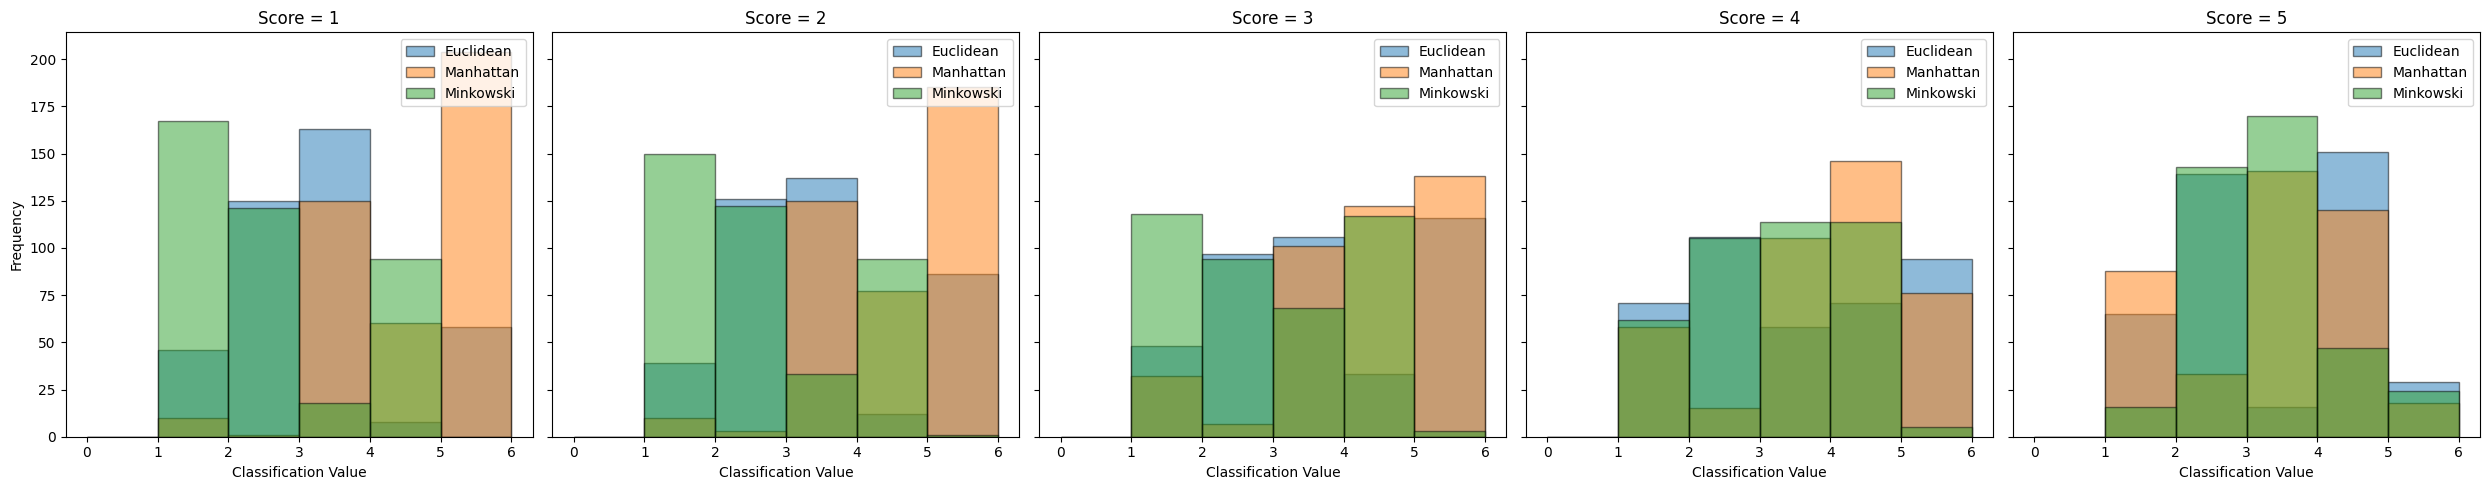

In [53]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

for i in range(1, 6):
    ax = axes[i-1]
    filtered_df = new_df[new_df['score'] == i]
    
    ax.hist(filtered_df['classification_euclidean'], bins=range(0, 7), alpha=0.5, label='Euclidean', edgecolor='black')
    ax.hist(filtered_df['classification_mahattan'], bins=range(0, 7), alpha=0.5, label='Manhattan', edgecolor='black')
    ax.hist(filtered_df['classification_minkowski'], bins=range(0, 7), alpha=0.5, label='Minkowski', edgecolor='black')
    
    ax.set_title(f'Score = {i}')
    ax.set_xlabel('Classification Value')
    if i == 1:
        ax.set_ylabel('Frequency')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

The indexes for classes after kmeans algorithm do not coincide with real scores. Before you could see the distribution of scores and classes assigned to them. As you could notice, some scores tend to share kmeans classes. 

### Part 5: Visualize results and write a conclusion.

To visualise points i shrink dimensionality of data to 2

In [54]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
points = model.fit_transform(embeddings) 

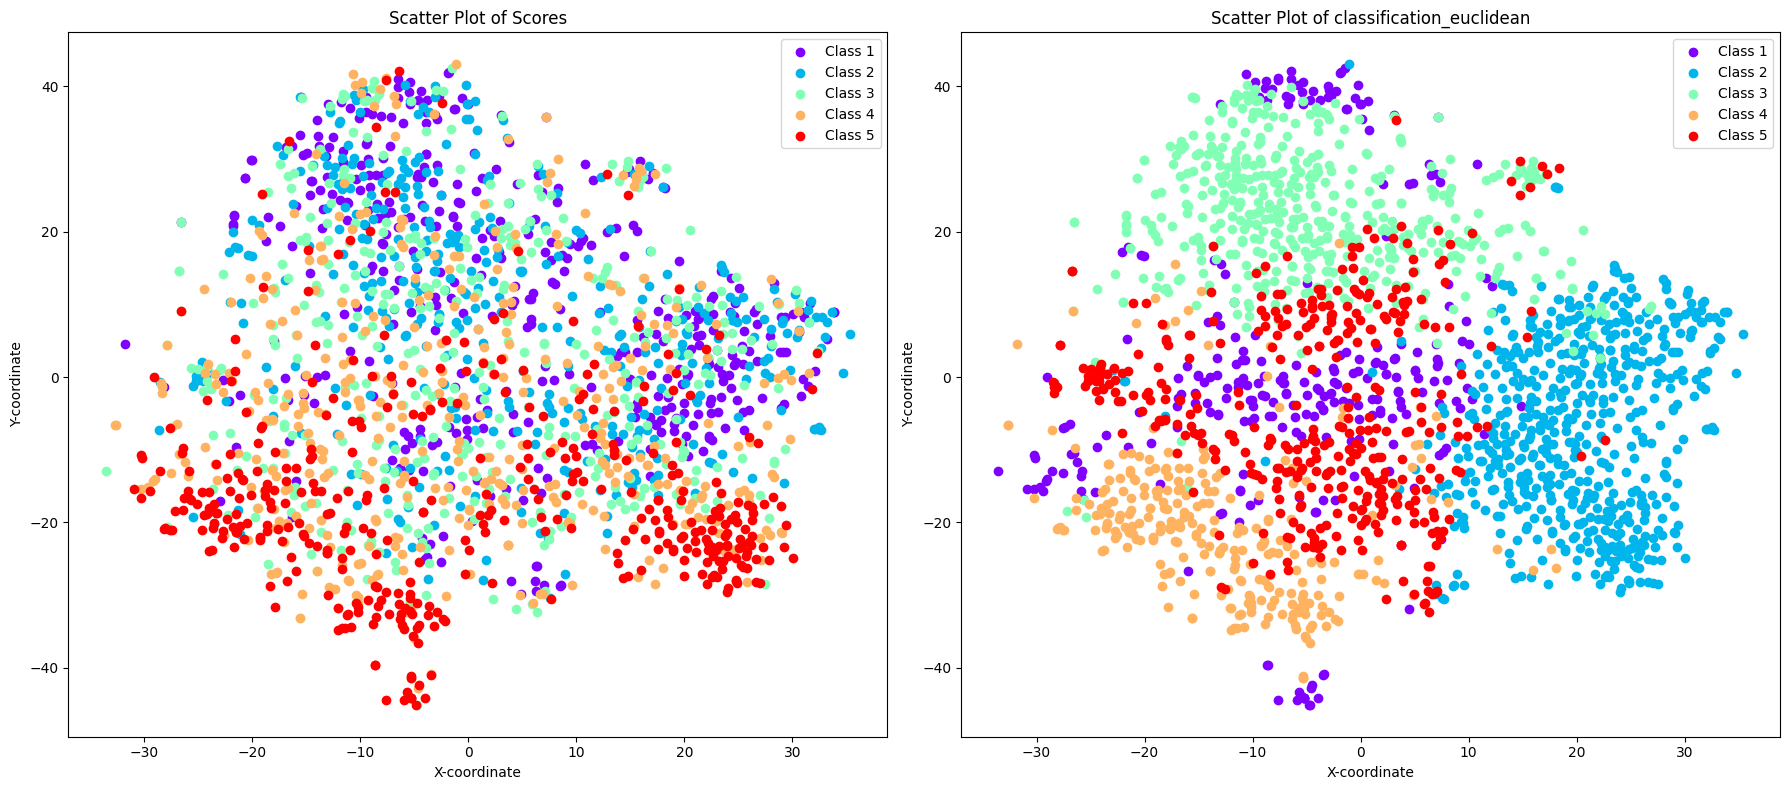

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

unique_classes = np.unique(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
classes = np.array(new_df['score'])

for cls, color in zip(unique_classes, colors):
    axes[0].scatter(points[classes == cls, 0], points[classes == cls, 1], label=f'Class {cls}', color=color)
axes[0].set_title('Scatter Plot of Scores')
axes[0].set_xlabel('X-coordinate')
axes[0].set_ylabel('Y-coordinate')
axes[0].legend()
classes = np.array(new_df['classification_euclidean'])
for cls, color in zip(unique_classes, colors):
    axes[1].scatter(points[classes == cls, 0], points[classes == cls, 1], label=f'Class {cls}', color=color)
axes[1].set_title('Scatter Plot of classification_euclidean')
axes[1].set_xlabel('X-coordinate')
axes[1].set_ylabel('Y-coordinate')
axes[1].legend()

plt.tight_layout()
plt.show()

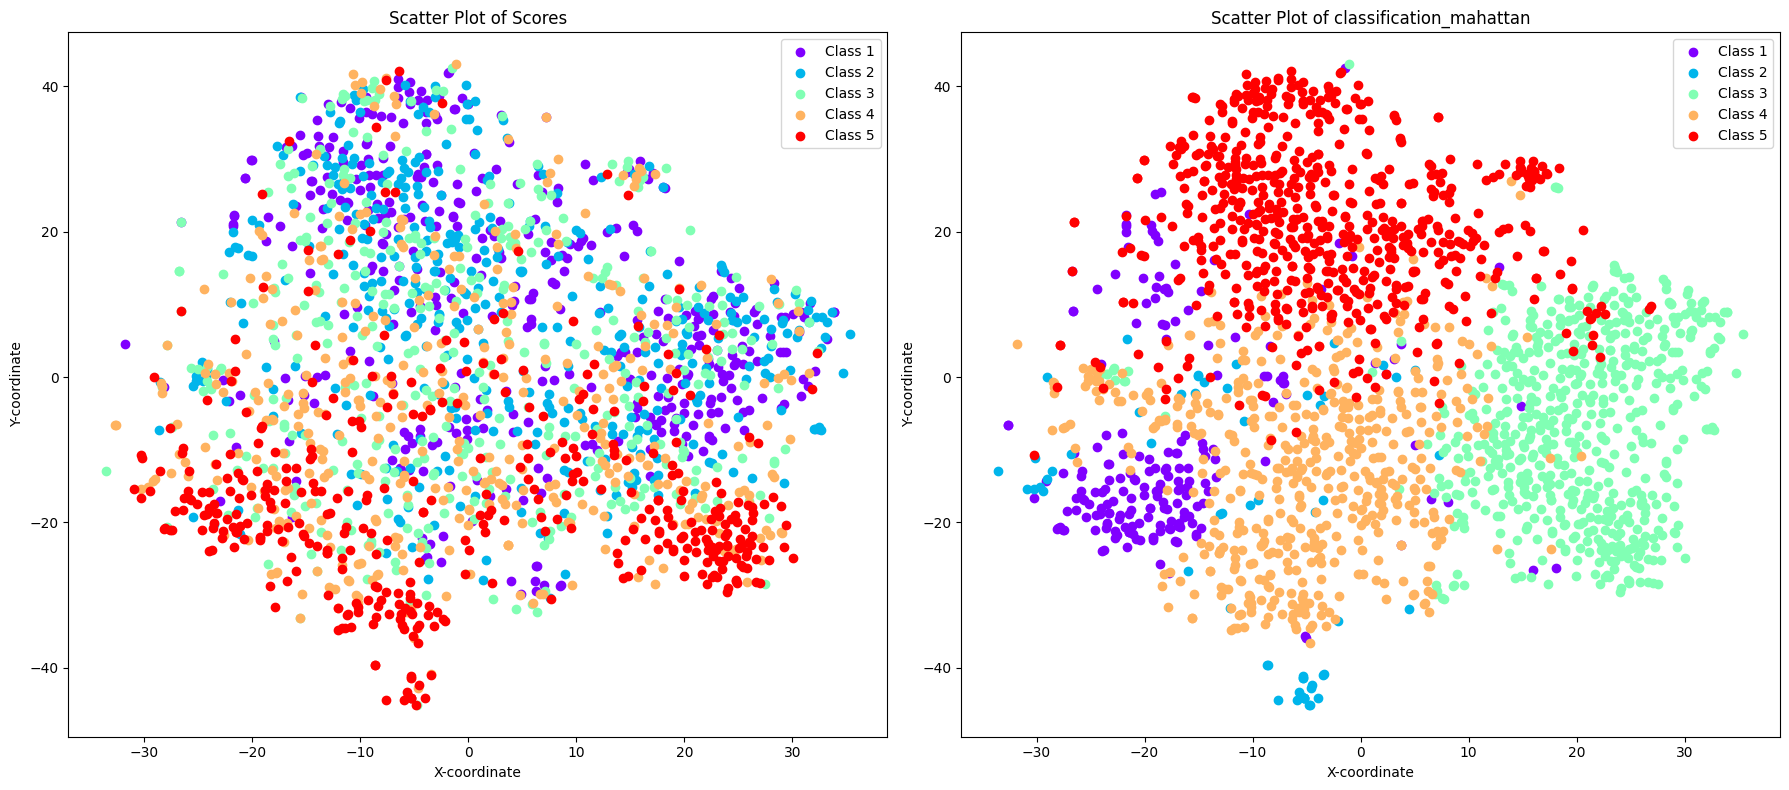

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

unique_classes = np.unique(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
classes = np.array(new_df['score'])

for cls, color in zip(unique_classes, colors):
    axes[0].scatter(points[classes == cls, 0], points[classes == cls, 1], label=f'Class {cls}', color=color)
axes[0].set_title('Scatter Plot of Scores')
axes[0].set_xlabel('X-coordinate')
axes[0].set_ylabel('Y-coordinate')
axes[0].legend()
classes = np.array(new_df['classification_mahattan'])
for cls, color in zip(unique_classes, colors):
    axes[1].scatter(points[classes == cls, 0], points[classes == cls, 1], label=f'Class {cls}', color=color)
axes[1].set_title('Scatter Plot of classification_mahattan')
axes[1].set_xlabel('X-coordinate')
axes[1].set_ylabel('Y-coordinate')
axes[1].legend()

plt.tight_layout()
plt.show()

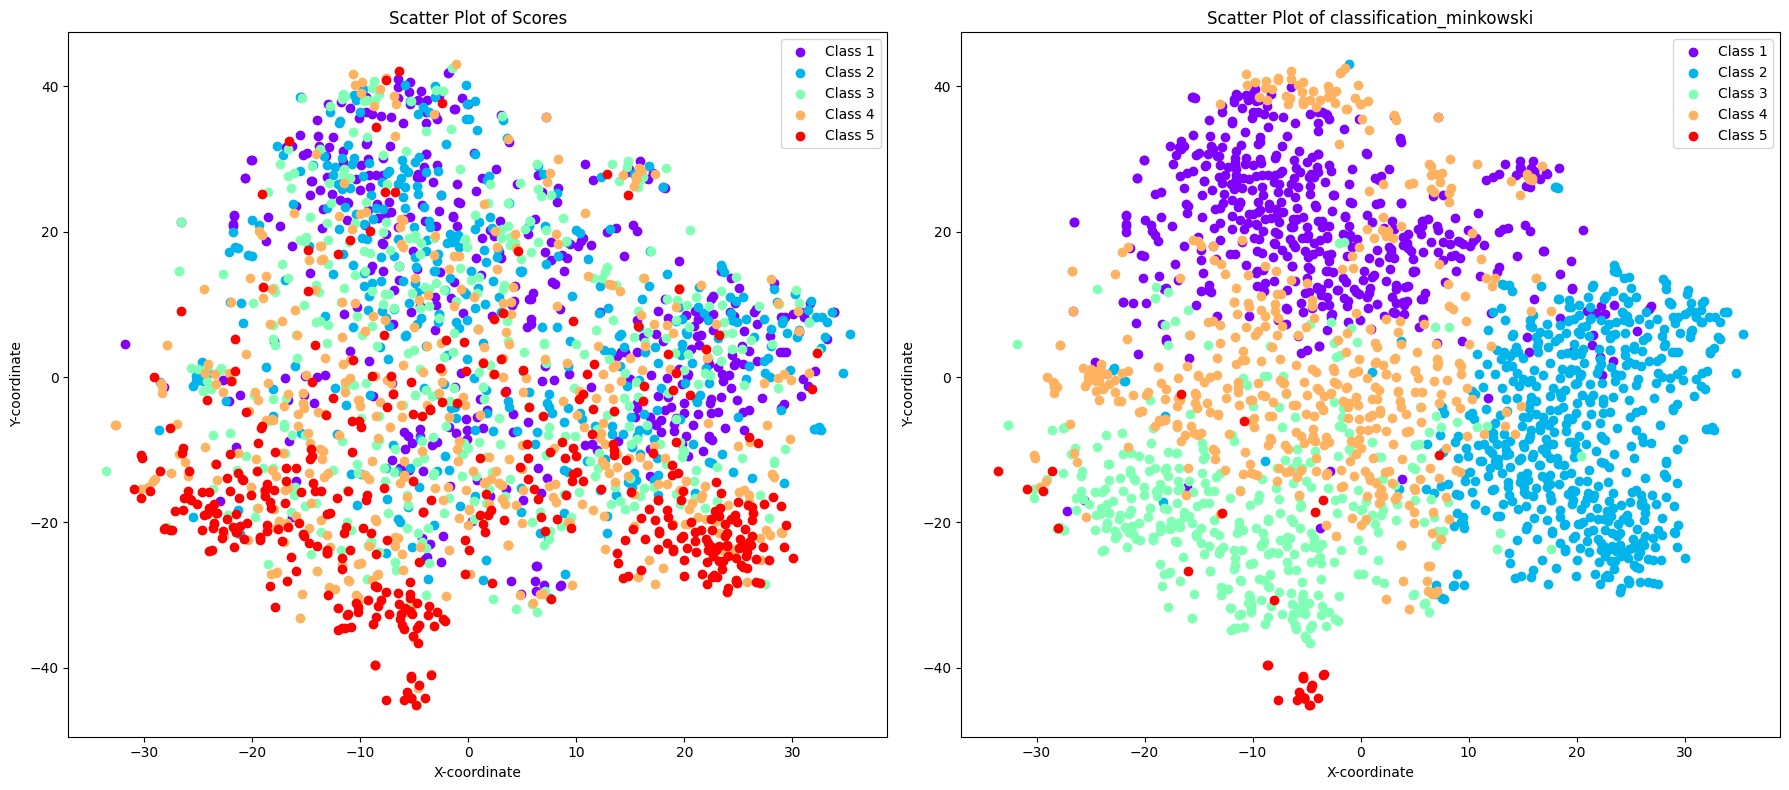

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

unique_classes = np.unique(classes)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_classes)))
classes = np.array(new_df['score'])

for cls, color in zip(unique_classes, colors):
    axes[0].scatter(points[classes == cls, 0], points[classes == cls, 1], label=f'Class {cls}', color=color)
axes[0].set_title('Scatter Plot of Scores')
axes[0].set_xlabel('X-coordinate')
axes[0].set_ylabel('Y-coordinate')
axes[0].legend()
classes = np.array(new_df['classification_minkowski'])
for cls, color in zip(unique_classes, colors):
    axes[1].scatter(points[classes == cls, 0], points[classes == cls, 1], label=f'Class {cls}', color=color)
axes[1].set_title('Scatter Plot of classification_minkowski')
axes[1].set_xlabel('X-coordinate')
axes[1].set_ylabel('Y-coordinate')
axes[1].legend()

plt.tight_layout()
plt.show()

As you could notice, the classes initially are mixed, but after kmeans they're grouped.

Conclusion: the embeddings vectors distribution is more complicated for negative and positive messages then just grouping.